In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import pyforest
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',1000)

In [2]:
loan=pd.read_csv('loan.csv')
loan1=loan.copy()
# impute gender with most freq category
loan1['Gender']=loan1['Gender'].fillna('Male')
# impute gender with most freq category
loan1['Dependents']=loan1['Dependents'].fillna('0')
# impute gender with most freq category
loan1['Self_Employed']=loan1['Self_Employed'].fillna('No')
# as the distribution is skewed, we'll do for median imputation
loan1['LoanAmount']=loan1['LoanAmount'].fillna(loan1['LoanAmount'].median())
# we'll do for mean imputation
loan1['Loan_Amount_Term']=loan1['Loan_Amount_Term'].fillna(loan1['Loan_Amount_Term'].mean())
# impute gender with most freq category
loan1['Credit_History']=loan1['Credit_History'].fillna(1.0)
# impute gender with most freq category
loan1['Married']=loan1['Married'].fillna('Yes')
# drop loanid
loan1.drop('Loan_ID',axis=1,inplace=True)

In [3]:
from sklearn.preprocessing import LabelEncoder
def le(df,col):
    lab=LabelEncoder()
    df[col]=pd.Series(lab.fit_transform(df[col]))

In [4]:
le(loan1,'Gender')
le(loan1,'Married')
le(loan1,'Dependents')
le(loan1,'Education')
le(loan1,'Self_Employed')
le(loan1,'Property_Area')
le(loan1,'Loan_Status')

In [5]:
from scipy.stats import zscore
z=np.abs(zscore(loan1))
loan1=loan1[(z<3).all(axis=1)]

x=loan1.drop('Loan_Status',axis=1)
y=loan1['Loan_Status']

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate
from sklearn.metrics import roc_curve, roc_auc_score

# Now, let's define some functions to reuse them
def fitc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    
def get_scorec(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    train_score=m.score(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return train_score,test_score

def get_predc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    return pred

def get_metricsc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    acc=accuracy_score(pred,y_test)
    conf=confusion_matrix(pred,y_test)
    clas=classification_report(pred,y_test)
    return acc,conf,clas

from sklearn.model_selection import GridSearchCV
def gridcvc(m,p,x,y):
    gkb=GridSearchCV(m,p,n_jobs=-1,cv=5,scoring='accuracy')
    gkb.fit(x,y)
    return gkb.best_params_


from sklearn.model_selection import RandomizedSearchCV
def randomcvc(m,p,x,y):
    from sklearn.model_selection import RandomizedSearchCV
    gkb=RandomizedSearchCV(estimator=m,param_distributions=p,
                          cv=5,n_iter=75,
                          n_jobs=-1, verbose=5,return_train_score=True,random_state=45)
    gkb.fit(x,y)
    return gkb.best_params_

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
def bfec(m,x,y,k):
    sf=sfs(m, k_features=k, forward=False, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xbfe=x[feat_names]
    return xbfe

def ffsc(m,x,y,k):
    sf=sfs(m, k_features=k, forward=True, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xffs=x[feat_names]
    return xffs

from sklearn.decomposition import PCA
def nforpcac(x):
    pca=PCA().fit(x)
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
    plt.xlabel('No of Components')
    plt.ylabel('Variance')
    plt.axhline(y=95, color='r', linestyle='--')
    plt.show()
    
def pcac(m,x,n):
    pca=PCA(n_components=n)
    xpca=pd.DataFrame(pca.fit_transform(x))
    return xpca

def crossc(m,x,y,c=5):
    score=cross_val_score(m,x,y,cv=c,n_jobs=-1)
    return (score.mean(), score.std())

from sklearn.preprocessing import StandardScaler
def stdc(x):
    scx=StandardScaler()
    xs=pd.DataFrame(scx.fit_transform(x), columns=x.columns)
    return xs

from sklearn.preprocessing import MinMaxScaler
def mmc(x):
    mm=MinMaxScaler()
    xm=pd.DataFrame(mm.fit_transform(x), columns=x.columns)
    return xm

def modified_bfec(m,x,y,k):
    sf=sfs(m, k_features=k, forward=False, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xbfe=x[feat_names]
    x_train, x_test, y_train, y_test=train_test_split(xbfe,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def modified_ffsc(m,x,y,k):
    sf=sfs(m, k_features=k, forward=True, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xffs=x[feat_names]
    x_train, x_test, y_train, y_test=train_test_split(xffs,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def modified_pcac(m,x,y,n):
    pca=PCA(n_components=n)
    xpca=pd.DataFrame(pca.fit_transform(x))
    x_train, x_test, y_train, y_test=train_test_split(xpca,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def ttsc(x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    return x_train, x_test, y_train, y_test

def classification(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    clas=classification_report(pred,y_test)
    return clas

lrc=LogisticRegression(n_jobs=-1,random_state=45)
dtc=DecisionTreeClassifier(random_state=45)
svc=SVC(random_state=45)
knnc=KNeighborsClassifier(n_jobs=-1)
rfc=RandomForestClassifier(n_jobs=-1,random_state=45)
gbc=GradientBoostingClassifier(random_state=45)
xgbc=XGBClassifier(n_jobs=-1,random_state=45)
adac=AdaBoostClassifier(random_state=45)
gnb=GaussianNB()
mnb=MultinomialNB()

In [7]:
xs=stdc(x)
x_sk=x.copy()

# x_sk['ApplicantIncome'].min(), x_sk['ApplicantIncome'].max()
x_sk['ApplicantIncome']=np.log(x_sk['ApplicantIncome'])
# skewness reduced to -0.20
# x_sk['CoapplicantIncome'].min(), x_sk['CoapplicantIncome'].max()
x_sk['CoapplicantIncome']=np.cbrt(x_sk['CoapplicantIncome'])
# skewness reduced to -0.03
# x_sk['LoanAmount'].min(), x_sk['LoanAmount'].max()
x_sk['LoanAmount']=np.cbrt(x_sk['LoanAmount'])
# skewness reduced to 0.05
# x_sk['Loan_Amount_Term'].min(), x_sk['Loan_Amount_Term'].max()
x_sk['Loan_Amount_Term']=np.power(x_sk['Loan_Amount_Term'],2.5)
# skewness reduced to 0.05
# x_sk['Dependents'].min(), x_sk['Dependents'].max()
x_sk['Dependents']=np.power(x_sk['Dependents'],1/5)
# skewness reduced to 0.43

xs_sk=stdc(x_sk)

# GNB

In [8]:
# GNB with xs_sk 0.8171296296296297, 0.8

In [9]:
# gnb=GaussianNB()

In [10]:
# Individual Model Pipeline:
# 1. feature selection
# 2. Hyper parameter tuning
# 3. Boosting
# 4. Cross Validation
# 5. Evaluation Metrics

In [11]:
# lets apply BFE
# there are 11 features
for i in range(7,12):
    print(i," ",modified_bfec(gnb,xs_sk,y,i))

7   0.8068965517241379
8   0.8
9   0.8068965517241379
10   0.8068965517241379
11   0.8


In [12]:
# at k=7, score improved a little

In [13]:
# PCA
# take n from 8 to 12
for i in range(4,12):
        print(i," ",modified_pcac(gnb,xs_sk,y,i))

4   0.6896551724137931
5   0.7931034482758621
6   0.7793103448275862
7   0.7724137931034483
8   0.7724137931034483
9   0.7448275862068966
10   0.7517241379310344
11   0.7655172413793103


In [14]:
# we'll use bfe
xs_sk_bfe1=bfec(gnb,xs_sk,y,7)
xs_sk_bfe1.head()

,Gender,Dependents,Education,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,0.477137,-0.815080,-0.541961,-1.093504,-0.000207,0.170743,0.418513
1,0.477137,1.015323,-0.541961,0.596681,-0.000207,0.170743,0.418513
2,0.477137,-0.815080,-0.541961,-1.093504,-1.435403,0.170743,0.418513
3,0.477137,-0.815080,1.845150,0.868268,-0.154386,0.170743,0.418513
4,0.477137,-0.815080,-0.541961,-1.093504,0.237176,0.170743,0.418513


In [15]:
get_scorec(gnb,xs_sk_bfe1,y)

(0.8148148148148148, 0.8068965517241379)

In [16]:
# lets tune the model

In [17]:
GaussianNB?

In [18]:
# there are no options available

In [19]:
# lets try to boost it

In [28]:
adagnb=AdaBoostClassifier(random_state=45,base_estimator=gnb,n_estimators=300,learning_rate=0.1)
get_scorec(adagnb,xs_sk_bfe1,y)

(0.8263888888888888, 0.8137931034482758)

In [29]:
# the score improved a little bit

In [30]:
# lets cross val adagnb,xs_sk_bfe1,y

In [31]:
for i in range(2,13):
    print(i," ",crossc(adagnb,xs_sk_bfe1,y,i))

2   (0.8145905420991926, 0.018742791234140743)
3   (0.8164012695656891, 0.024827560725598514)
4   (0.8198957412319482, 0.03314315986357295)
5   (0.8182114206054868, 0.03411283885008954)
6   (0.8198694760957377, 0.03784484937158596)
7   (0.8165857390071319, 0.04729159303845593)
8   (0.8164800255107509, 0.0514340071237084)
9   (0.814685931352598, 0.05570535333807699)
10   (0.8182644110275689, 0.05107158285206695)
11   (0.816344382382118, 0.04755903917467836)
12   (0.8163189921358613, 0.05157405148050329)


In [32]:
# no under fitting or over fitting

In [33]:
# Evaluation metrics
acc, conf, clas=get_metricsc(adagnb,xs_sk_bfe1,y)
print(acc)
print(' ')
print(conf)
print(' ')
print(clas)

0.8137931034482758
 
[[21  3]
 [24 97]]
 
              precision    recall  f1-score   support

           0       0.47      0.88      0.61        24
           1       0.97      0.80      0.88       121

    accuracy                           0.81       145
   macro avg       0.72      0.84      0.74       145
weighted avg       0.89      0.81      0.83       145



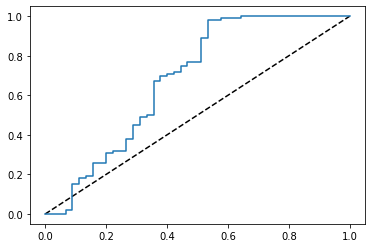

In [34]:
# auc roc
xtr,xte,ytr,yte=ttsc(xs_sk_bfe1,y)
adagnb.fit(xtr,ytr)
y_pred_pro=adagnb.predict_proba(xte)[:,1]
fpr,tpr,threshold=roc_curve(yte,y_pred_pro)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr,tpr,label='LRC')
plt.show()

In [35]:
roc_auc_score(yte,y_pred_pro)

0.6831111111111111